<hr style="border:1px solid #FEC60D"> </hr>
<center><h1 style="color:#173F8A;"> FUNDAMENTOS MATEMATICOS PARA INTELIGENCIA ARTIFICIAL</h1></center> 
<center><h1 style="color:#173F8A;"> IMT 3850 </h1></center>
<hr style="border:1px solid #FEC60D"> </hr>
<center><h3 style="color:#0176DE;text-align:right;"> Profesor. Manuel A. Sanchez<br></h3></center>
<h3 style="color:#03122E;text-align:right;"> Magister en Inteligencia Artificial - MIA <br> Instituto de Ingenieria Matematica y Computacional - IMC<br>  Pontificia Universidad Catolica de Chile<br>   </h3>




<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->



<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Algebra Lineal para IA - clase 2</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

## Tabla de contenidos:
1. [Independencia Lineal. Metodo de Gram-Schmidt](#Independencia-Lineal.-Metodo-de-Gram-Schmidt") 
2. [Ejemplo: Matriz de diferencias](#Ejemplo:-Matriz-de-diferencias) 
3. [Sistemas dinamicos lineales: dinamica de epidemias toy problem](#Sistemas-dinamicos-lineales:-dinamica-de-epidemias-toy-problem)
4. [Ejemplo Matriz de diferencias de segundo orden: ](#Ejemplo-Matriz-de-diferencias-de-segundo-orden: )
5. [Ejemplo: Convolucion Image blurring](#Ejemplo:-Convolucion-Image-blurring)
6. [Ejemplo: Interpolacion polinomial](#Ejemplo:-Interpolacion-polinomial)
7. [Ejemplo: problema de Poisson](#Ejemplo:-problema-de-Poisson)
8. [Ejemplo: factorizacion LU scipy](#Ejemplo:-factorizacion-LU-scipy)
9. [Ejemplo: solver usando factorizacion LU](#Ejemplo:-Solver-PA-=-LU) 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.linalg as LA
from IPython.display import display, HTML
import matplotlib.animation as animation
display(HTML("""<style>.output {display: flex;align-items: center;text-align: center;}</style>"""))

## Independencia Lineal. Metodo de Gram Schmidt

In [3]:
def GramSchmidt_clasico(A):
    m = A.shape[0]; n = A.shape[1]
    R = np.zeros((n,n))
    Q = np.zeros((m,n))
    for j in range(0, n):
        vj = A[:,j]
        for i in range(0,j):
            R[i,j] = np.dot(Q[:,i],A[:,j])
            vj = vj - R[i,j]*Q[:,i]
            
        # end for
        R[j,j] = np.linalg.norm(vj)
        Q[:,j] = (1.0/R[j,j])*vj
    # end for
    return Q, R

def GramSchmidt_modificado(A):
    m = A.shape[0]; n = A.shape[1]
    R = np.zeros((n,n))
    Q = np.zeros((m,n))
    v = np.zeros((m,n))
    for i in range(0, n):
        v[:,i] = A[:,i]
    for i in range(0, n):
        R[i,i] = np.linalg.norm(v[:,i])
        Q[:,i] = (1.0/R[i,i])*v[:,i]
        for j in range(i,n):
            R[i,j] = np.dot(Q[:,i],v[:,j])
            v[:,j]= v[:,j] - R[i,j]*Q[:,i]
        # end for
    # end for
    return Q, R

In [4]:
a1  =np.array([-1,1,-1,1])
a2 = np.array([-1,3,-1,3])
a3 = np.array([1,3,5,7])
A = np.column_stack([a1,a2,a3])
Q,_ = GramSchmidt_clasico(A)
print(Q)

[[-0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5  0.5  0.5]]


In [5]:
Q, R = GramSchmidt_modificado(A)
print(Q)

[[-0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5  0.5  0.5]]


## Ejemplo: Comparacion Gram-Schmidt clasico vs modificado

In [6]:
ep = 10**(-7)
A = np.ones((10,10)) + ep*np.eye((10));
#print(A)
Q, R = GramSchmidt_clasico(A)
print("*** Gram-Schmidt clasico.\n")
print("    || A - QR ||2    :", np.linalg.norm(A -np.dot(Q,R)))
print("    || Q.T@Q - I ||2 :", np.linalg.norm(np.dot(Q.T, Q)-np.eye(10)))
print("    || q1*q2 ||2     :", np.dot(Q[:,1], Q[:,2]))

Q, R = GramSchmidt_modificado(A)
print("\n\n ")
print("*** Gram-Schmidt modified.\n")
print("    || A - QR ||2    :", np.linalg.norm(A -np.dot(Q,R)))
print("    || Q.T@Q - I ||2 :", np.linalg.norm(np.dot(Q.T, Q)-np.eye(10)))

print("    || q1*q2 ||2     :", np.dot(Q[:,1], Q[:,2]))

*** Gram-Schmidt clasico.

    || A - QR ||2    : 9.019494489765868e-16
    || Q.T@Q - I ||2 : 0.3674695563835977
    || q1*q2 ||2     : -0.005948312637853892


 
*** Gram-Schmidt modified.

    || A - QR ||2    : 1.0295784775289034e-15
    || Q.T@Q - I ||2 : 7.830815093173928e-09
    || q1*q2 ||2     : -4.440892098500626e-16


## Algoritmo  de Householder

### Proyecciones de Householder

Resumen del proceso:

Queremos crear una matriz ortogonal de forma más estable que usando el proceso de Gramm-Schmidt, que empieza a ser muy inestable ante columnas muy cercanas a ser L.D.

Para esto, usamos las proyecciones de householder, que insertan 0's en algunas entradas de la matriz.

Veremos un ejemplo de como realizar este procedimiento en una matriz de $5\times 5$.

$$A = \begin{pmatrix}
2&1&1&1&1\\
2&1&1&2&1\\
0&1&2&1&1\\
3&2&1&1&1\\
1&0&0&1&0
\end{pmatrix}$$

Primero, queremos armar una transformación $P_1$ sobre $A$ tal que:

$$P_1A = \begin{pmatrix}
x&x&x&x&x\\
0&x&x&x&x\\
0&x&x&x&x\\
0&x&x&x&x\\
0&x&x&x&x
\end{pmatrix}$$

En este caso, podemos crearla como:

$$\tilde{u} = a_1 + \text{sign}(a_{11})\|a_1\|_2e_1 = \begin{pmatrix}2 + 3\sqrt{2}\\2\\0\\3\\1\end{pmatrix}$$

$$u = \frac{\tilde{u}}{\|\tilde{u}\|_2}$$

$$P_1 = I_5 - 2uu^T$$

[6.24264069 2.         0.         3.         1.        ]
[0.85773088 0.27479745 0.         0.41219618 0.13739873]


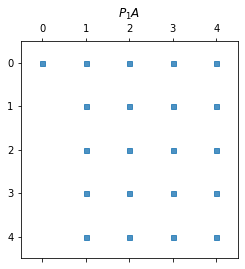

In [22]:
A = np.array([[2, 1, 1, 1, 1],
              [2, 1, 1, 2, 1],
              [0, 1, 2, 1, 1],
              [3, 2, 1, 1, 1],
              [1, 0, 0, 1, 0]], dtype=float)

I5 = np.eye(5)
e1 = I5[:,0]

u_tilde = A[:,0] + e1*np.linalg.norm(A[:,0])*np.sign(A[0,0])
print(u_tilde)

u = u_tilde/np.linalg.norm(u_tilde)
print(u)

P1 = I5 - 2*np.outer(u, u)

plt.spy(P1@A, precision=1e-14, alpha=0.8, markersize=5)
plt.title("$P_1A$")
plt.show()

#print(P1@A)

Aplicamos entonces el mismo proceso a la submatriz $A[2:5, 2:5]$, sin arruinar lo ya logrado. Esto es, aplicamos una matriz $P_2$ a $P_1A$ tal que:

$$P_2P_1A = \begin{pmatrix}
x&x&x&x&x\\
0&x&x&x&x\\
0&0&x&x&x\\
0&0&x&x&x\\
0&0&x&x&x
\end{pmatrix}$$

Para esto, $P_2$ debe ser como:

$$\begin{pmatrix}
1&0&0&0&0\\
0&y&y&y&y\\
0&y&y&y&y\\
0&y&y&y&y\\
0&y&y&y&y
\end{pmatrix}$$

donde la submatríz de $y$ se construye de manera análoga a la $P_1$. Veamos esto en código:

u:
 [-0.72898256  0.57069287  0.22070379 -0.30689398]
P2:
 [[ 1.          0.          0.          0.          0.        ]
 [ 0.         -0.06283115  0.83205029  0.32177843 -0.44744072]
 [ 0.          0.83205029  0.3486193  -0.25190816  0.35028441]
 [ 0.          0.32177843 -0.25190816  0.90257967  0.13546533]
 [ 0.         -0.44744072  0.35028441  0.13546533  0.81163217]]


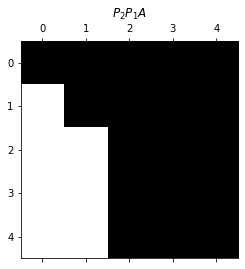

P2P1A:
 [[-4.24264069e+00 -2.35702260e+00 -1.64991582e+00 -2.35702260e+00
  -1.64991582e+00]
 [ 5.55111512e-17  1.20185043e+00  1.75655062e+00  3.69800131e-01
   9.24500327e-01]
 [-1.11022302e-16  1.11022302e-16  7.43096518e-01  1.43424286e+00
   3.94477214e-01]
 [-1.34874750e-16  0.00000000e+00 -7.59540786e-01 -4.45335917e-01
  -5.07632629e-01]
 [-2.22044605e-16 -2.77555756e-17  2.51422060e-01  2.28726119e-01
  -9.88623524e-02]]


In [24]:
B = P1@A #Guardandola en otra variable solo para efectos de visualización

I4 = np.eye(4)
e1 = I4[:,0]

u_tilde = B[1:,1] + e1*np.linalg.norm(B[1:,1])*np.sign(B[1,1])
u = u_tilde/np.linalg.norm(u_tilde)

print("u:\n", u)

P2_tilde = I4 - 2*np.outer(u, u)

P2 = np.eye(5)
P2[1:,1:] = P2_tilde

print("P2:\n", P2)

plt.spy(P2@P1@A, precision=1e-14)
plt.title("$P_2P_1A$")
plt.show()

print("P2P1A:\n",P2@P1@A)

Obviamente, podríamos hacer todo este proceso a mano, pero empieza a ser tedioso bastante rápido. Con esto, logramos construir una matriz triangular superior, a la que llamaremos $R$ como resultado de:

$$R = P_5P_4P_3P_2P_1A$$

Y la matriz ortogonal resultante corresponde a:

$$Q = (P_5P_4P_3P_2P_1)^{-1} = P_1^{-1}P_2^{-1}P_3^{-1}P_4^{-1}P_5^{-1} = P_1^{T}P_2^{T}P_3^{T}P_4^{T}P_5^{T}$$

Así, podemos lograr la descomposición QR de $A$ de forma más estable que con el algoritmo de GS. Revisemos el código de `HouseholderQR`

In [44]:
def HouseholderQR(A, show_plot=False):
    """
    Una implementación ineficiente de HH-QR
    Input: A matriz de mxn, m >= n
    Output: (Q, R) matrices tales que A = QR
            Q: ortogonal de mxm
            R: triangular superior de mxn
    """
    
    m, n = A.shape
    R = np.copy(A)     # Buenas prácticas de código, nunca modificar el input
                       # Es preferible hacer una copia del input si queremos trabajar con él
    Q = np.identity(m)
    RALL = []
    RALL.append(R.copy())
    ims = []
    fig=[]
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,8))
    for k in range(n):
        
        x = R[k:,k]    # Tomamos la columna k de la submatriz de R que comienza en la fila k
        Lx = x.shape[0]
     
        v = x + np.sign(x[0])*np.linalg.norm(x, ord=2)*np.eye(1, M=Lx)[0] #armamos el vector u_tilde
        v = v/np.linalg.norm(v, ord=2) # armamos el vector u
        
        # Innecesario! Podemos hacer todo esto sin almacenar las matrices P!
        Pk = np.eye(Lx) - 2*np.outer(v,v)
        
        #Actualización A
        R[k:,k:] = Pk@R[k:,k:]
        RALL.append(R.copy())
        if show_plot:
            #Vemos que se hace
            im = ax.spy(RALL[k], precision=1e-14, animated=True)
            if k == 0:
                ax.spy(RALL[k],precision=1e-14) 
        
            title = "Iteracion Householder, n = %s" % k
            ax.set_title(title)
            ims.append([im])
            #plt.show()
        
        #Actualización Q
        P = np.eye(m)
        P[k:,k:] = Pk
        Q = Q@P.T

    return Q, R, RALL, ims, fig

7.59043014889755e-14


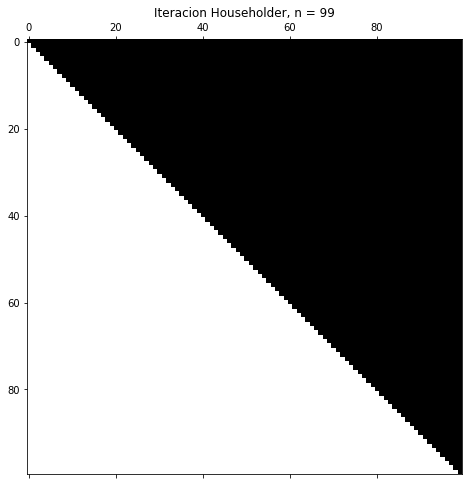

In [45]:
A = LA.hilbert(100)
A = np.random.rand(100,100)
b = np.ones(100)
QH, RH, RALL, ims, fig = HouseholderQR(A, show_plot=True)
print(np.linalg.norm(QH@RH - A))

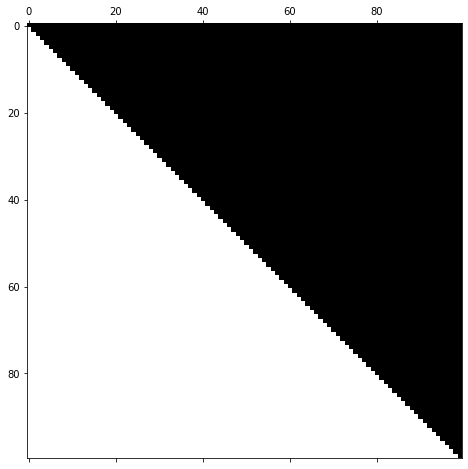

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
ims = []
for i in range(100):
    #title = "Iteracion Householder, n = %s" % i
    #ax.set_title(title)
    im = ax.spy(RALL[i],precision=1e-14, animated=True)
    
    if i == 0:
        ax.spy(RALL[i], precision=1e-14)  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
ani.save("HouseholderQR.gif")

plt.show()

## Ejemplo: comparacion de algoritmos

In [48]:
def compare(M):
    # compare three QR decomposition: 1) Gram-Schmidt clasico, 2) Gram-Schmidt modificado, 3) Householder
    
    Q, R = GramSchmidt_clasico(M);
    
    errorQRLinf = np.linalg.norm(np.matmul(Q,R) - M, np.inf)
    errororthLinf = np.linalg.norm(np.matmul(Q.T,Q) - np.eye(Q.shape[0]), np.inf)
    
    print("*** Gram-Schmidt clasico.\n")
    print("    ||Q*R-M ||_inf   : ",errorQRLinf)
    print("    ||Q'*Q - I||_inf : ", errororthLinf)
    
    
    Q, R = GramSchmidt_modificado(M);
    
    errorQRLinf = np.linalg.norm(np.matmul(Q,R) - M, np.inf)
    errororthLinf = np.linalg.norm(np.matmul(Q.T,Q) - np.eye(Q.shape[0]), np.inf)
    
    print("\n\n ")
    print("*** Gram-Schmidt modified.\n")
    print("    ||Q*R-M ||_inf   : ",errorQRLinf)
    print("    ||Q'*Q - I||_inf : ", errororthLinf)
    
    
    Q, R, RALL, ims, fig = HouseholderQR(M, show_plot=False)
    #Q, R = np.linalg.qr(M)
    errorQRLinf = np.linalg.norm(np.matmul(Q,R) - M, np.inf)
    errororthLinf = np.linalg.norm(np.matmul(Q.T,Q) - np.eye(Q.shape[0]), np.inf)
    
    print("\n\n")
    print("*** Householder.\n")
    print("    ||Q*R-M ||_inf   : ",errorQRLinf)
    print("    ||Q'*Q - I||_inf : ", errororthLinf)
    
    Q, R = np.linalg.qr(M)
    errorQRLinf = np.linalg.norm(np.matmul(Q,R) - M, np.inf)
    errororthLinf = np.linalg.norm(np.matmul(Q.T,Q) - np.eye(Q.shape[0]), np.inf)
    
    print("\n\n")
    print("*** numpy.linalg.qr\n")
    print("    ||Q*R-M ||_inf   : ",errorQRLinf)
    print("    ||Q'*Q - I||_inf : ", errororthLinf)
    
    
    pass

In [49]:
# Matriz de Hilbert
n = 8; H = np.zeros((n,n));
for i in range(n):
    for j in range(n):
        H[i,j] = 1.0/(i+j+1);
    # end for
# end for
#print(H)
compare(H)

*** Gram-Schmidt clasico.

    ||Q*R-M ||_inf   :  1.6653345369377348e-16
    ||Q'*Q - I||_inf :  1.1070375538332562


 
*** Gram-Schmidt modified.

    ||Q*R-M ||_inf   :  3.3306690738754696e-16
    ||Q'*Q - I||_inf :  2.084031924653755e-07



*** Householder.

    ||Q*R-M ||_inf   :  1.915134717478395e-15
    ||Q'*Q - I||_inf :  1.7293103043095117e-15



*** numpy.linalg.qr

    ||Q*R-M ||_inf   :  5.828670879282072e-16
    ||Q'*Q - I||_inf :  1.4095144313937556e-15


## Ejemplo: Matriz de diferencias

In [4]:
n=40
D = np.zeros((n-1,n))
for i in range(n-1):
    D[i,i] = -1.0
    D[i,i+1] = 1.0
print(D[0:4,0:5])

[[-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]]


Aproximar la derivada de una funcion usando la matriz de diferencias.

$$
u(x) = \sin(2\pi t), \quad t\in(0,1)
$$

Usamos una grilla equi-espaciada de n-puntos del intervalo $(0,1)$, esto es, tomamos

$$
t_{i} = \frac{i}{(n-1)},\quad 0\leq i\leq n-1
$$

y calculamos la funcion evaluada en estos puntos, lo que nos da el vector 

$$
b_{i} = u(t_{i-1}), \quad 1\leq i \leq n.  
$$

Ahora, el nuevo vector $D b$ approxima la derivada de $u$.

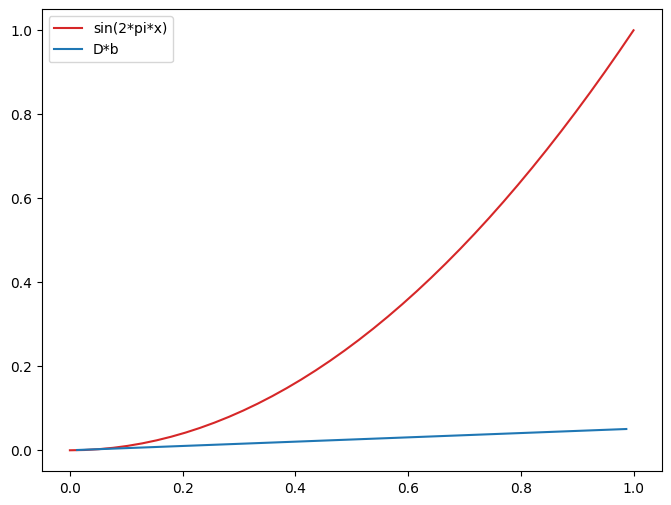

In [6]:
t = np.array([ i/(n-1) for i in range(n)])
AV = np.zeros((n-1,n))
for i in range(n-1):
    AV[i,i] = .5
    AV[i,i+1] = .5
tmid = AV.dot(t)

# b = np.sin(2*np.pi*t)
# x = D.dot(b)*(n-1)/(2*np.pi)

b = t**2
x = D.dot(b)
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(t, b, 'C03',label='sin(2*pi*x)')

ax.plot(tmid, x, 'C00', label='D*b')
ax.legend()
plt.show()



## Sistemas dinamicos lineales: dinamica de epidemias toy problem

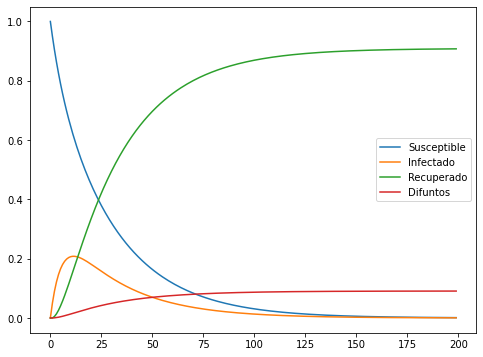

In [7]:
A = np.array([[0.95, 0.04, 0,0],[0.05,0.85,0,0],[0,0.1,1,0],[0,0.01,0,1]])
# inicial:
m = 200
X = np.zeros((4,m))
x0 = np.array([1,0.00001,0,0])
X[:,0] = x0
for t in range(m-1):
    X[:,t+1] = A.dot(X[:,t])

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(np.arange(m), X[0,:], 'C00',label='Susceptible')
ax.plot(np.arange(m), X[1,:], 'C01',label='Infectado')
ax.plot(np.arange(m), X[2,:], 'C02',label='Recuperado')
ax.plot(np.arange(m), X[3,:], 'C03',label='Difuntos')
ax.legend()
plt.show()

## Ejemplo Matriz de diferencias de segundo orden: 

$$ - u''(x) = (4 \pi^2) \sin(2\pi x),\quad u(0) = u(1) = 0$$

In [8]:
def Matrizdediferencias(n):
    Dn = np.zeros((n-1,n))
    for i in range(n-1):
        Dn[i,i] = -1.0
        Dn[i,i+1] = 1.0
    return Dn

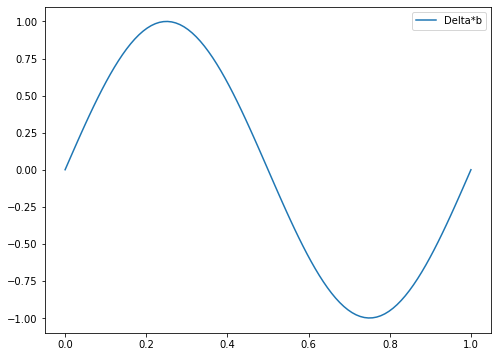

In [9]:
n=100
Dn = Matrizdediferencias(n)
Dnm1 = Matrizdediferencias(n-1)
Delta = Dnm1.dot(Dn)

t = np.array([ i/(n-1) for i in range(n)])
b = np.sin(2*np.pi*t) *(4*np.pi**2)

x = np.zeros(n)
x[0] = 0
x[1:n-1] = -(1/(n-1)**2)*np.linalg.solve(Delta[:,1:n-1], b[1:n-1])
x[-1] = 0
fig, ax = plt.subplots(1,1, figsize=(8,6))
#ax.plot(t, b, 'C03',label='sin(2*pi*x)')

ax.plot(t, x, 'C00', label='Delta^{-1}*b')
ax.legend()
plt.show()

## Ejemplo: Convolucion Image blurring

Sea $A\in \mathbb R^{m\times n}$ y $B\in \mathbb R^{p\times q}$. Su convolucion es la matriz $C\in \mathbb R^{(m+p-1)\times (n+q-1)}$

\begin{equation}
C_{rs} = \sum_{i+k=r+1}\sum_{j+l=s+1} A_{ij}B_{kl},\qquad 1\leq r\leq m+p-1,\,1\leq s\leq n+q-1
\end{equation}


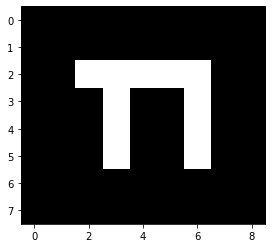

In [10]:
from scipy.signal import convolve2d
B = 0.25*np.ones((2,2))
X = np.array([[1,1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1,1],
              [1,1,0,0,0,0,0,1,1],
              [1,1,1,0,1,1,0,1,1],
              [1,1,1,0,1,1,0,1,1],
              [1,1,1,0,1,1,0,1,1],
              [1,1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1,1]])

plt.imshow(X, cmap=plt.cm.binary)

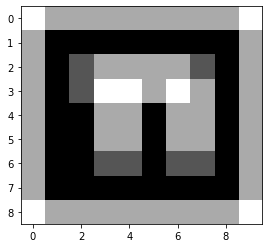

In [11]:
Y = convolve2d(X,B)
plt.imshow(Y, cmap=plt.cm.binary)

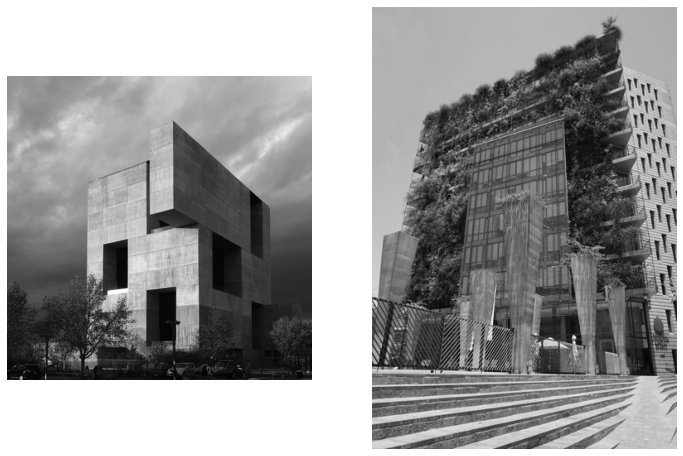

In [12]:
img1 = Image.open('edif_elemental.png')
img2 = Image.open('PATIO-ALAMEDA-UC.jpeg')
img1gray = img1.convert('LA')
img2gray = img2.convert('LA')
figure, ax = plt.subplots(1,2,figsize=(12, 15))
ax[0].imshow(img1gray)
ax[0].axis('off')
ax[1].imshow(img2gray)
ax[1].axis('off')
plt.show()

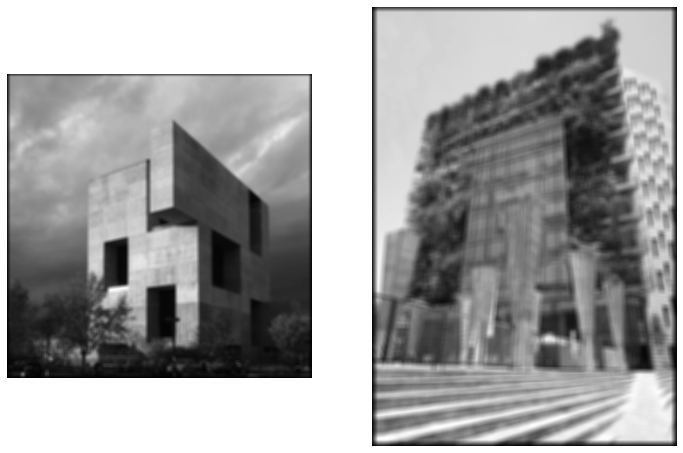

In [13]:

img1mat = np.array(list(img1gray.getdata(band=0)), float)
img1mat.shape = (img1gray.size[1], img1gray.size[0])
img1mat = np.matrix(img1mat)

B = (1/64)*np.ones((8,8))
img1blurred=convolve2d(img1mat,B)

img2mat = np.array(list(img2gray.getdata(band=0)), float)
img2mat.shape = (img2gray.size[1], img2gray.size[0])
img2mat = np.matrix(img2mat)

B = (1/64)*np.ones((8,8))
img2blurred=convolve2d(img2mat,B)

figure, ax = plt.subplots(1,2, figsize=(12, 15))
ax[0].imshow(img1blurred, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(img2blurred, cmap=plt.cm.gray)
ax[1].axis('off')
plt.show()

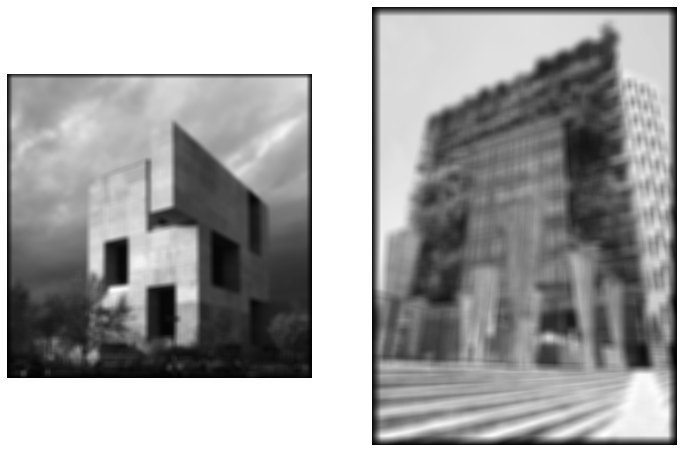

In [14]:
img1mat = np.array(list(img1gray.getdata(band=0)), float)
img1mat.shape = (img1gray.size[1], img1gray.size[0])
img1mat = np.matrix(img1mat)

B = (1/144)*np.ones((12,12))
img1blurred=convolve2d(img1mat,B)

img2mat = np.array(list(img2gray.getdata(band=0)), float)
img2mat.shape = (img2gray.size[1], img2gray.size[0])
img2mat = np.matrix(img2mat)

img2blurred=convolve2d(img2mat,B)

figure, ax = plt.subplots(1,2, figsize=(12, 15))
ax[0].imshow(img1blurred, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(img2blurred, cmap=plt.cm.gray)
ax[1].axis('off')
plt.show()

## Ejemplo: Interpolacion polinomial

Considere el problema de encontrar los coeficientes del polinomio cubico que $p(x) = c_1 + c_2x + c_3 x^2 + c_4 x^3$ que interpola los valores $b_1, b_2, b_3, b_4$ en los puntos $x = -1.1, -0.4, 0.2, 0.8$.
Resolvemos generando la matriz de Vandermonde
\begin{equation}
A = \begin{bmatrix}
1 & -1.1 & (-1.1)^{2} & (-1.1)^{3} \\
1 & -0.4 & (-0.4)^{2} & (-0.4)^{3} \\
1 &  0.2 & ( 0.2)^{2} & ( 0.2)^{3} \\
1 &  0.8 & ( 0.8)^{2} & ( 0.8)^{3} 
\end{bmatrix}
\end{equation}

In [7]:
A = np.array([[1 , -1.1 , (-1.1)**2 , (-1.1)**3 ],
              [1 , -0.4 , (-0.4)**2 , (-0.4)**3 ],
              [1 ,  0.2 , ( 0.2)**2 , ( 0.2)**3 ],
              [1 ,  0.8 , ( 0.8)**2 , ( 0.8)**3 ]], dtype=np.float64)
x = np.array([-1.1, -0.4, 0.2, 0.8])

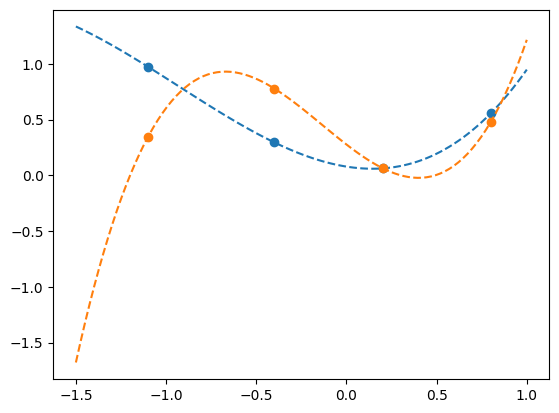

In [9]:
b1 = np.random.rand(4)
b2 = np.random.rand(4)
c1 = np.linalg.solve(A,b1)
c2 = np.linalg.solve(A,b2)

xplot = np.linspace(-1.5, 1, 100)
fig, ax = plt.subplots(1,1)
ax.plot(xplot, np.polyval(c1[::-1], xplot), '--', color='C00')
ax.plot(x, np.polyval(c1[::-1], x), 'o', color='C00')
ax.plot(xplot, np.polyval(c2[::-1], xplot), '--', color='C01')
ax.plot(x, np.polyval(c2[::-1], x), 'o', color='C01')
plt.savefig('polynomialcubic.png')
plt.show()

## Ejemplo: problema de Poisson

Considere la ecuacion diferencial
\begin{equation}
-\Delta u(x) = f(x), \quad\mbox{en }\Omega,\quad u = 0,\quad \mbox{sobre } \partial \Omega
\end{equation}
Caso unidimensional, tenemos la ecuacion
$$ - u''(x) = (4 \pi^2) \sin(2\pi x),\quad u(0) = u(1) = 0$$
cuya solucion es la funcion $u(x) = \sin(2\pi x)$.

Aproximamos usando matrices de diferencias

In [5]:
def Matrizdediferencias(n):
    Dn = np.zeros((n-1,n))
    for i in range(n-1):
        Dn[i,i] = -1.0
        Dn[i,i+1] = 1.0
    return Dn
def uexacta(t):
    return np.sin(2*np.pi*t)

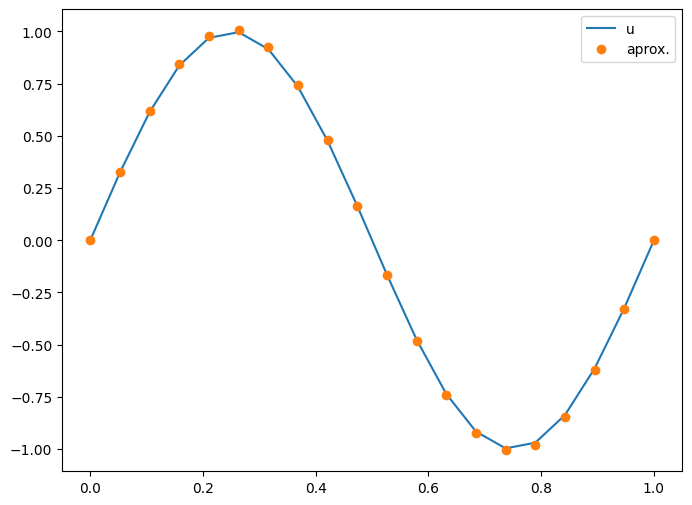

In [6]:
n=20
Dn = Matrizdediferencias(n)
Dnm1 = Matrizdediferencias(n-1)
Delta = Dnm1.dot(Dn)

t = np.array([ i/(n-1) for i in range(n)])
b = np.sin(2*np.pi*t) *(4*np.pi**2)

x = np.zeros(n)
x[0] = 0
x[1:n-1] = -(1/(n-1)**2)*np.linalg.solve(Delta[:,1:n-1], b[1:n-1])
x[-1] = 0
fig, ax = plt.subplots(1,1, figsize=(8,6))
#ax.plot(t, b, 'C03',label='sin(2*pi*x)')

ax.plot(t, uexacta(t), color='C00', label='u')
ax.plot(t, x, 'o', color='C01', label='aprox.')
ax.legend()
plt.show()

## Ejemplo: factorizacion LU scipy
Sea la matriz
\begin{equation}
A = 
\begin{bmatrix}
3 & 17 & 10 \\
2 & 4  &-2  \\
6 & 187 &-12
\end{bmatrix}
\end{equation}


In [8]:
import scipy.linalg as lg
A = np.array([[3,17,10],[2,4,-2],[6,18,-12]], dtype=np.float64)
P,L,U = lg.lu(A)
print(" P:\n", P.T)
print("\n L:\n", L)
print("\n U:\n", U)
print("\n P A - L U:\n", P.T@A - L@U)

 P:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]

 L:
 [[ 1.          0.          0.        ]
 [ 0.5         1.          0.        ]
 [ 0.33333333 -0.25        1.        ]]

 U:
 [[  6.  18. -12.]
 [  0.   8.  16.]
 [  0.   0.   6.]]

 P A - L U:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## Ejemplo: Solver PA = LU

Algoritmos de sustitucion regresiva y progresiva

In [9]:
def sus_reg(U_input,b_input):
    U = U_input.copy()
    b = b_input.copy()
    n = U.shape[0]
    b[n-1] = b[n-1]/U[n-1,n-1]
    for i in range(n-2,-1,-1):
        b[i] = (b[i] - U[i,(i+1):n].dot(b[(i+1):n]))/U[i,i]
    return b
def sus_prog(L_input,b_input):
    L = L_input.copy()
    b = b_input.copy()
    n = L.shape[0]
    b[0] = b[0]/L[0,0]
    for i in range(1,n):
        b[i] = (b[i] - L[i,0:(i)].dot(b[0:(i)]))/L[i,i]
    return b
def solve_PLU(A, b):
    P,L,U = lg.lu(A)
    y = sus_prog(L,P.T.dot(b))
    x = sus_reg(U,y)
    return x

Los usamos en conjunto con la factorizacion $LU$ para resolver un sistema lineal $Ax = b$ y comparamos las soluciones.

In [10]:
A = np.array([[3,17,10],[2,4,-2],[6,18,-12]], dtype=np.float64)
b = np.array([1.0,1.0,-1.0])
xsol = np.linalg.solve(A, b)
myxsol = solve_PLU(A,b)
print("solucion numpy: \n",xsol)
print("solucion solve_PLU:\n", myxsol)

solucion numpy: 
 [ 1.54861111 -0.38194444  0.28472222]
solucion solve_PLU:
 [ 1.54861111 -0.38194444  0.28472222]


In [ ]:
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=150,n_features=2,
                           centers=2,cluster_std=1.05,
                           random_state=2)
#Plotting
fig = plt.figure(figsize=(10,8))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'r^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title('Random Classification Data with 2 classes')

def step_func(z):
        return 1.0 if (z > 0) else 0.0
import numpy as np
def perceptron(X, y, lr, epochs):
       
    # X --> Inputs.
    # y --> labels/target.
    # lr --> learning rate.
    # epochs --> Number of iterations.
    
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    # Initializing parapeters(theta) to zeros.
    # +1 in n+1 for the bias term.
    theta = np.zeros((n+1,1))
    
    # Empty list to store how many examples were 
    # misclassified at every iteration.
    n_miss_list = []
    
    # Training.
    for epoch in range(epochs):
        
        # variable to store #misclassified.
        n_miss = 0
        
        # looping for every example.
        for idx, x_i in enumerate(X):
            
            # Insering 1 for bias, X0 = 1.
            x_i = np.insert(x_i, 0, 1).reshape(-1,1)
            
            # Calculating prediction/hypothesis.
            y_hat = step_func(np.dot(x_i.T, theta))
            
            # Updating if the example is misclassified.
            if (np.squeeze(y_hat) - y[idx]) != 0:
                theta += lr*((y[idx] - y_hat)*x_i)
                
                # Incrementing by 1.
                n_miss += 1
        
        # Appending number of misclassified examples
        # at every iteration.
        n_miss_list.append(n_miss)
        
    return theta, n_miss_list

def plot_decision_boundary(X, theta):
    
    # X --> Inputs
    # theta --> parameters
    
    # The Line is y=mx+c
    # So, Equate mx+c = theta0.X0 + theta1.X1 + theta2.X2
    # Solving we find m and c
    x1 = [min(X[:,0]), max(X[:,0])]
    m = -theta[1]/theta[2]
    c = -theta[0]/theta[2]
    x2 = m*x1 + c
    
    # Plotting
    fig = plt.figure(figsize=(10,8))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "r^")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title("Perceptron Algorithm")
    plt.plot(x1, x2, 'y-')
theta, miss_l = perceptron(X, y, 0.5, 100)
plot_decision_boundary(X, theta)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
def yhat(x,w):
    return np.sign(np.dot(x,w))

In [80]:
# artificial data
npts = 500
X = np.random.rand(npts,2)*6-3
labels = np.ones(X.shape[0], dtype=np.int64)
labels[(X[:,1]<X[:,0]+1)]=-1
X = np.c_[X, np.ones(X.shape[0])]

In [81]:
winit = np.random.randn(3)
w = winit

In [94]:

for i,j in zip(X, labels):
    w = w - (yhat(i,w)-j)*i 

In [95]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels,[yhat(i,w) for i in X]))

0.984


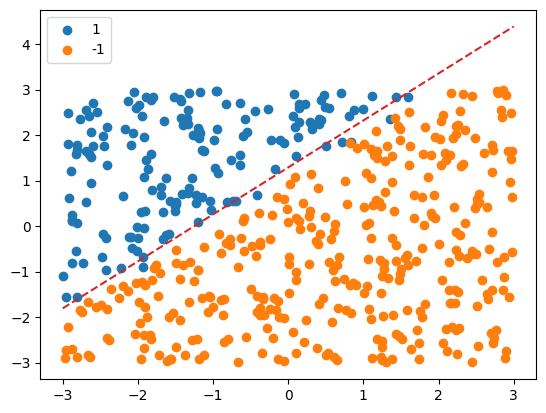

In [96]:

yline = lambda x: (-w[0]*x -w[2])/w[1]


marker_pos=[]
marker_neg=[]
for j in range(X.shape[0]):
    if labels[j] == 1:
        marker_pos.append(j)
    else:
        marker_neg.append(j)
fig, ax = plt.subplots(1,1)
ax.scatter(X[marker_pos,0], X[marker_pos,1], label='1')
ax.scatter(X[marker_neg,0], X[marker_neg,1], label='-1')
xplot = np.linspace(-3,3,10)
ax.plot(xplot, yline(xplot),'--', color='C03')
ax.legend()
plt.show()